 Importing Libraries

In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

Initialising model arguments

In [2]:
# Construct the parser and initialise arguments
parser = argparse.ArgumentParser(description='COVID-CNN')

parser.add_argument('--epochs', default=10, type=int, help='Number of epochs')
parser.add_argument('--lr', default=0.0002, type=float, help='Learning rate')
parser.add_argument('--bs', default=8, type=int, help='Batch size')
parser.add_argument('--datadir', default='data', type=str, help='Path to data folder')
parser.add_argument('--trainfile', default='train_split.txt', type=str, help='Name of train file')
parser.add_argument('--testfile', default='test_split.txt', type=str, help='Name of test file')
parser.add_argument("-p", "--plot", type=str, default="plot.png", help="Path to output loss/accuracy plot")
parser.add_argument("-m", "--model", type=str, default="covid19.model", help="Path to output loss/accuracy plot")
parser.add_argument('--input_size', default=480, type=int, help='Size of input (ex: if 480x480, --input_size 480)')
args, unknown = parser.parse_known_args()

# Parameters
LR = args.lr
BS = args.bs
display_step = 1
EPOCHS=args.epochs
print(args)

Namespace(bs=8, datadir='data', epochs=10, input_size=480, lr=0.0002, model='covid19.model', plot='plot.png', testfile='test_split.txt', trainfile='train_split.txt')


Loading and preprocessing the dataset

In [ ]:
with open(args.trainfile) as f:
    trainFiles = f.readlines()
with open(args.testfile) as f:
    testFiles = f.readlines()

def loadData(dataDir, dataFiles, folder):
    # loop over the image paths
    data, labels = [] , []
    for dataFile in dataFiles:
        # extract the class label from the filename
        label = dataFile.split()[-2]
        # load the image, swap color channels, and resize it to be a fixed
        # 224x224 pixels while ignoring aspect ratio
        image = cv2.imread(os.path.join(dataDir, folder, dataFile.split()[1]))
        #TODO: Change and check model performance
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        # update the data and labels lists, respectively
        data.append(image)
        labels.append(label)
    # convert the data and labels to NumPy arrays while scaling the pixel
    # intensities to the range [0, 1]
    data = np.array(data) / 255.0
    labels = np.array(labels)
    return data, labels

trainData, trainLabels = loadData(args.datadir, trainFiles, "train")
testData, testLabels = loadData(args.datadir, testFiles, "test")


In [3]:
#trainData.shape
print(testLabels)

NameError: name 'testLabels' is not defined

In [7]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
trainLabels = lb.fit_transform(trainLabels)
#trainLabels = to_categorical(trainLabels)
testLabels = lb.fit_transform(testLabels)
#testLabels = to_categorical(testLabels)

# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=15,
    fill_mode="nearest")

In [8]:
testLabels

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [9]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [10]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=LR, decay=LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(trainData, trainLabels, batch_size=BS),
	steps_per_epoch=len(trainData) // BS,
	validation_data=(testData, testLabels),
	validation_steps=len(testData) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 1740 steps, validate on 1579 samples
Epoch 1/10
1740/1740 [==============================] - 190s 109ms/step - loss: 0.6552 - accuracy: 0.7350 - val_loss: 0.5881 - val_accuracy: 0.7849
Epoch 2/10
1740/1740 [==============================] - 133s 76ms/step - loss: 0.5366 - accuracy: 0.8056 - val_loss: 0.5295 - val_accuracy: 0.8065
Epoch 3/10
1740/1740 [==============================] - 124s 72ms/step - loss: 0.4960 - accuracy: 0.8230 - val_loss: 0.5080 - val_accuracy: 0.8166
Epoch 4/10
1740/1740 [==============================] - 124s 71ms/step - loss: 0.4685 - accuracy: 0.8312 - val_loss: 0.4750 - val_accuracy: 0.8211
Epoch 5/10
1740/1740 [==============================] - 124s 71ms/step - loss: 0.4559 - accuracy: 0.8342 - val_loss: 0.4693 - val_accuracy: 0.8211
Epoch 6/10
1740/1740 [==============================] - 119s 68ms/

In [12]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testData, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testLabels.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

    COVID-19       1.00      0.05      0.10       100
      normal       0.86      0.95      0.90       885
   pneumonia       0.81      0.82      0.82       594

   micro avg       0.84      0.84      0.84      1579
   macro avg       0.89      0.61      0.60      1579
weighted avg       0.85      0.84      0.82      1579



In [20]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testLabels.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1] +cm[2,2]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[  5  32  63]
 [  0 837  48]
 [  0 107 487]]
acc: 0.8417
sensitivity: 0.1351
specificity: 1.0000


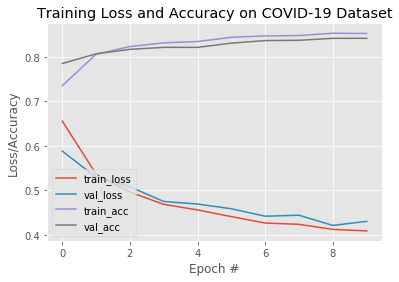

In [17]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args.plot)

In [19]:
# serialize the model to disk
print("[INFO] saving COVID-19 detector model...")
model.save(args.model, save_format="h5")

[INFO] saving COVID-19 detector model...
